                                             Workshop 5: Dragos Gruia and Valentina Giunchiglia

# Graph theory analysis: probing the normal and abnormal connectome

In this workshop, we are going to use graph theory and represent functional MRI data as a connected graph. The nodes in our graph will correspond to regions of interest (ROI) in the brain, and the edges between nodes will be based on a measure of functional connectivity between each pair of regions. A ROI The purpose of building the graph is to be able to come up with concise and powerful descriptions of the complex organisation of the brain. 

### Graphs and regions of interest (ROIs)

There are typically 1000s or 100,000s of voxels in a brain scan. Depending on the research hypothesis, we may want to reduce this down to something more manageable. Especially if we are running connectivity analyses in a pairwise manner because the number of connections increases exponentially with the number of nodes. Typically, we choose a smaller number of 'regions of interest' (ROI) and just focus on these to make the analysis tractable. As we will see, these ROIs will be the starting point for defining a graph, composed of 'nodes' (ROIs) and their 'edges' (the functional connectivity between nodes). Graph theory has many metrics that are useful for describing/summarising the functional connectivity of the brain as a whole. 

### Examples of a graph

Here's some examples of the brain as a graph or network. (Taken from Vertes et al, 2013, Phil Trans Royal Society B) 

PIC HERE

A ROI can be defined in lots of different ways, again depending on the research question. Here, we will use a recent parcellation that combined many different imaging modalities to define ROIs that cover the entire brain. 

### A parcellation of the brain

The Human Connectome Project parcellation of the brain (Taken from Glasser et al, 2016, Nature). 

PIC HERE

### What we're going to do 

Load some resting-state fMRI data

* Extract some ROI timecourses for each of our ROIs

* Build a graph from these ROI timecourses

* Calculate some graph theory metrics

* Marvel at our creation

* Do some exercises along similar lines but comparing two conditions - placebo and the psychedelic state with LSD

## Step 1 - load some resting-state fMRI data and an atlas

We shall do some analysis on resting-state fMRI data for a single subject. Resting-state data lack an explicit task: the subject is asked to lie in the scanner and not think about anything in particular (if that's possible). 

For this tutorial the relevant data files are in a directory called data (see Step 0 above). 

The file fmri.nii.gz is a 4D file containing the cleaned data. The file atlas.nii.gz is a file which contains a version of the parcellation displayed above, whereby each location in the brain is assigned a number, corresponding to the ROI which that voxel belongs to.

You might on a previous day in the course have used instead a single mask.

In [73]:
import nibabel as nib
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import seaborn as sb
import pandas as pd
%matplotlib inline
import numpy as np
import os
import warnings

warnings.filterwarnings('ignore')

sb.set_theme("talk")
sb.set_style("whitegrid")

In [9]:
fmri = nib.load("data/fmri.nii.gz")
atlas = nib.load("data/atlas.nii.gz")

fmri_arr = np.array(template.dataobj)
atlas_arr = np.array(mask.dataobj)

fmri_arr.shape, atlas_arr.shape

((91, 109, 91, 217), (91, 109, 91))

## Step 2 - visualise the atlas

It is possible to view the atlas (or the fMRI data) using third party tools like FSLeyes from the FSL neuroimaging suite of programs, which provides a useful interface and features to view 3D and 4D brain images. 

From within Matlab we also can quickly draw a 2D slice of the atlas, to see what it looks like in one plane: 



(-0.5, 108.5, 90.5, -0.5)

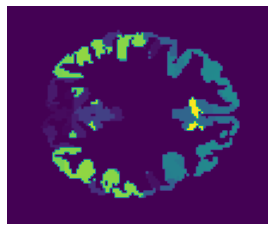

In [12]:
plt.imshow(atlas_arr[:, :, 50], cmap = "viridis")
plt.axis("off")

What is the meaning of the :,:,50 in this example? First try changing the number and then changing the order of those arguments.

You'll see that much of the image (and outside the brain) is empty since this is a cortical parcellation; i.e. it is not concerned with a lot of the brain in volumetric terms (i.e. white matter).

Before we continue about the atlas, you can view a similar 'slice' of the fMRI data:

(-0.5, 108.5, 90.5, -0.5)

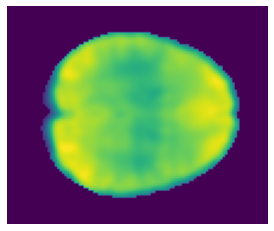

In [15]:
plt.imshow(fmri_arr[:, :, 50,123], cmap = "viridis")
plt.axis("off")

What is the meaning of the 123 in this example?

### The number of ROIs and the atlas numbering system

Each unique colour represents a unique integer identifier for a ROI. In the whole atlas there are 180 ROIs. You don't need to worry too much about which colours are used (although you could read about setting the colormap in Python to change the colour scheme of imagesc figures).

What is important to appreciate is that if you want to use the atlas properly, you need to know the range of numbers that is in the atlas, because in a minute we are going to use each of these numbers to extract a timecourse of the FMRI voxels that are at the same location as the ROI (that sit 'underneath' that region of the atlas image). 

Some atlases are labelled from 0 upwards, or 1 upwards; others have less obvious numbering that might start labelling regions from any old number. They might not even be contiguously numbered (i.e. it might be 1,2,50,51,100, rather than 1..180 straight).

Fortunately this atlas treats 'nothing' as 0, and then the numbers 1..180 represent our 180 ROIs.



## Step 3 - Extracting the timecourses

We want to extract the average timecourse from all of the voxels in each ROI. There are lots of ways to do this. Let's create a function that will do this for us, which we can re-use as we like. We're going to make a function extract_timecourse.m. 

You can paste the code in from below into your file, but look at how it works and try and understand it. The function is going to be passed the FMRI data and a binarised mask (you can get a clue about that from the name and number of the two arguments). This function will go through each voxel in the brain and check if the mask has a value of 1. If it does it will keep that timecourse. At the end, it uses the nanmean function in Python to find the average value at each time point across all the voxels (nanmean calculates a mean but will not break if there are NaN values, which mean Not a Number. In this case we aren't expecting any NaNs anyway). This results in the average timecourse for the whole ROI. It returns the timecourse in the variable timecourse as an array.

In [41]:
def extract_timecourse(fmri,mask):
    timecourse = []
    FunctionalConnectivityResults = np.zeros(fmri.shape[0:3]) # Create a variable full of zeros, which will later be replaced by the correlations coefficients we obtain between voxels
    for x in range(fmri.shape[0]):
        for y in range(fmri.shape[1]):
            for z in range(fmri.shape[2]):
                if mask[x, y, z] == 1:
                    timecourse.append(fmri[x,y,z,:])
    
    timecourse = np.transpose(timecourse)
    timecourse = np.nanmean(timecourse, axis=1)
    return np.array(timecourse)              
                    

Let's give the function a go. Let's ask it to extract the mean timecourse of the voxels 'in' ROI number 11, say.

In [ ]:
mask = atlas_arr == 11

In [49]:
tc = extract_timecourse(fmri_arr, mask)

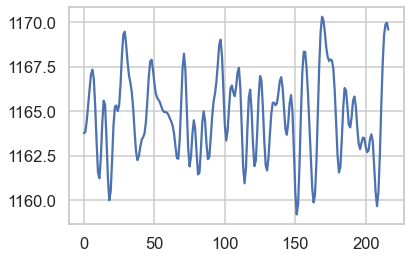

In [43]:
plt.plot(tc)

Think about what this is showing you, i.e. what is the y coordinate here? What is the 'x' coordinate?

Try changing the 11 above to a different ROI identifier, and see if your timecourse changes! What if you specify 181?

On its own a single timecourse is relatively uninteresting. What we want is to calculate timecourses for each of the ROIs. To do this we can use a for loop with our new function to extract all of the timecourses for ROI ids 1..180. We simply need to make a for loop and iterate over each ROI identifier, being sure to store the result somewhere.

In [53]:
fmri.shape[3]

217

In [57]:
All_ROI_Timecourses = np.zeros((fmri.shape[3],180))
for i in range(0,180):
    roi = atlas_arr == i
    All_ROI_Timecourses[:,i]  = extract_timecourse(fmri_arr,roi)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


Can you guess what the size of All_ROI_Timecourses will be? 

In [63]:

All_ROI_Timecourses.shape

(217, 180)

## Step 4 - Building a graph from our time courses

Remember a graph is made up of nodes and edges between them.

In our case, we will have one node for each ROI (i.e. 180 nodes).

How do we calculate edges between nodes? For any graph, we need to decide is there an edge (binary yes/no) between any given pair of nodes, and also (in some graphs, called weighted graphs), we ascribe each edge a value, or weight.

To calculate our edges between ROIs, we will calculate the functional connectivity between pairs of nodes. If there is functional connection between them, then there is an edge, and we can also create a version of the graph where the weight of each each corresponds to the 'strength' of functional connectivity.

Note that there are 101 ways to define functional connectivity, and lots of methodological considerations about the appropriate ways to do this. For our purposes here we are going to use a simple correlation. We can do this using the Python function corrcoef like we did in Day 4. The difference is that we want to work through each pair of nodes, rather than comparing every voxel to a 'seed'.

We need two for loops, to compare every node with every other node, and we store the results in a variable, here called 'pairwise_FC'. 

In [70]:
pairwise_FC = np.zeros((180,180))
for i in range (0,180):
    for j in range(0,180):
        pairwise_FC[i,j]=np.corrcoef(All_ROI_Timecourses[:,i], All_ROI_Timecourses[:,j])[0][1]


The resulting connectivity values are the edges of our graph. To get a good overview of the data we can look at this connectivity matrix

Text(0.5, 1.0, 'Functional connectivity')

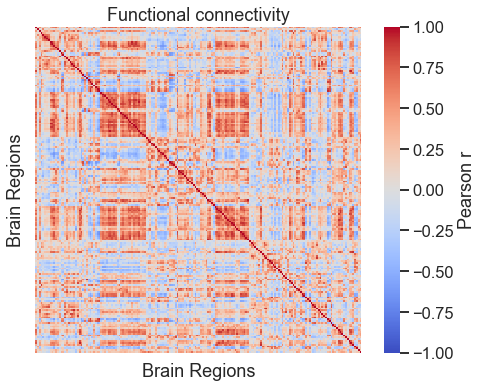

In [72]:
# Visualise FC for the first subject
f = plt.figure(figsize=(8, 6))
hm = sb.heatmap(pairwise_FC,
                xticklabels=False,
                yticklabels=False,
                cmap='coolwarm',
                cbar_kws={'label': 'Pearson r'},
                vmin=-np.nanmax(abs(pairwise_FC.flatten())),  # the matrix contains NaN values on the diagonal - this line and the next excludes those from the colormap
                vmax=np.nanmax(abs(pairwise_FC.flatten())))   # (as above)

hm.set_aspect('equal')                # make the heatmap plot square
plt.xlabel('Brain Regions', labelpad=10)
plt.ylabel('Brain Regions', labelpad=10)
plt.title('Functional connectivity')

This matrix is our graph (we just haven't drawn it as circles and lines between them). There are other functions and programs for plotting graphs, and tools for plotting graphs on brains, which you can try and explore if you have time.

In the current graph, every pair of nodes is connected by a weight (the R value from our correlation).

Often we want to restrict this just to a subset of the weights because:

1. We don't want connections that aren't really there influencing the results; and/or,
2. We may want to simplify the graph just to binary edges (there is an edge or there isn't).
One way to do this is based on whether the probability the functional connectivity between nodes was significantly greater than chance.

To do this, let's first recalculate the pairwise functional connectivity, but keep the p-values as well as the correlation coefficients. The corrcoef function does not give us the p-values so instead we will use pearsonr function.

In [75]:
pairwise_FC = np.zeros((180,180))
pairwise_pval = np.zeros((180,180))
for i in range (0,180):
    for j in range(0,180):
        pairwise_FC[i,j], pairwise_pval[i,j] = stats.pearsonr(All_ROI_Timecourses[:,i], All_ROI_Timecourses[:,j])


We can then use these p values to threshold the the pairwise_FC matrix (i.e. to avoid an edge, setting it to 0, if the p value is over some threshold, and keeping it otherwise).

We can also later binarise the matrix (i.e. set every non-zero value to 1) to make a binary or unweighted matrix/graph.

In [78]:
pairwise_FC_Thresh = np.zeros(pairwise_FC.shape)
for i in range (0,180):
    for j in range(0,180):
            if pairwise_pval[i,j] < 0.000001:
                pairwise_FC_Thresh[i,j]= pairwise_FC[i,j]


Text(0.5, 1.0, 'Functional connectivity')

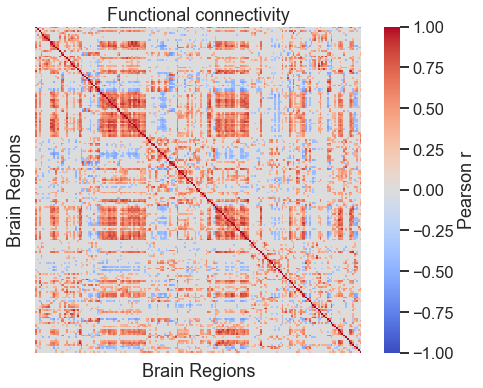

In [79]:
# Visualise FC for the first subject
f = plt.figure(figsize=(8, 6))
hm = sb.heatmap(pairwise_FC_Thresh,
                xticklabels=False,
                yticklabels=False,
                cmap='coolwarm',
                cbar_kws={'label': 'Pearson r'},
                vmin=-np.nanmax(abs(pairwise_FC.flatten())),  # the matrix contains NaN values on the diagonal - this line and the next excludes those from the colormap
                vmax=np.nanmax(abs(pairwise_FC.flatten())))   # (as above)

hm.set_aspect('equal')                # make the heatmap plot square
plt.xlabel('Brain Regions', labelpad=10)
plt.ylabel('Brain Regions', labelpad=10)
plt.title('Functional connectivity')

What is a sensible p value threshold here?

You can also make the graph binary, very simply: 

In [80]:
Binary_Thresh_FC_Graph= pairwise_FC_Thresh > 0


Text(0.5, 1.0, 'Functional connectivity')

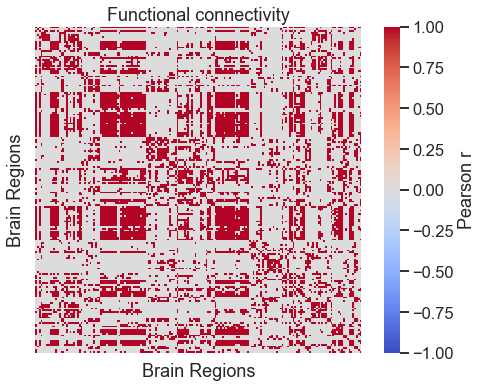

In [82]:
# Visualise FC for the first subject
f = plt.figure(figsize=(8, 6))
hm = sb.heatmap(Binary_Thresh_FC_Graph,
                xticklabels=False,
                yticklabels=False,
                cmap='coolwarm',
                cbar_kws={'label': 'Pearson r'},
                vmin=-np.nanmax(abs(pairwise_FC.flatten())),  # the matrix contains NaN values on the diagonal - this line and the next excludes those from the colormap
                vmax=np.nanmax(abs(pairwise_FC.flatten())))   # (as above)

hm.set_aspect('equal')                # make the heatmap plot square
plt.xlabel('Brain Regions', labelpad=10)
plt.ylabel('Brain Regions', labelpad=10)
plt.title('Functional connectivity')

## Step 5 - Simple graph metrics

The purpose of building the graph is to be able to come up with concise and powerful descriptions of the complex organisation of the brain.

We can have global measures (covering the whole brain) and local measures (calculated for each node).

We'll start with some simple, local measures: degree and strength. Degree is just how many connections a node has to other nodes (i.e., assuming the network is binary); strength is the average weight of connections each node has with other nodes.

PIC HERE

We want to take the graph we have created and loop through all of the nodes, and perform a calculation locally for each one: 

In [83]:
Degree = []
for i in range(0,Binary_Thresh_FC_Graph.shape[0]):
    Degree.append(np.sum(Binary_Thresh_FC_Graph[i,:]))

And to calculate the strength of each node, simply substitute in the weighted rather than binary graph: 'pairwise_FC_Thresh':

In [84]:
Strength = []
for i in range(0,Binary_Thresh_FC_Graph.shape[0]):
    Strength.append(np.sum(pairwise_FC_Thresh[i,:]))

These measures can tell us about:

1. how densely connected the graph is;
2. how evenly distributed the connections are.

For example, we can calculate the average degree:

In [85]:
np.mean(Degree)

52.922222222222224

Or the density: the proportion of connections out of all possible connections. To do this, calculate the total number of connections sum(Degree) and divide by the number of all possible connections, which is the number of nodes, (N*N-N)/2: 

In [87]:
K= np.sum(Degree)
N= Binary_Thresh_FC_Graph.shape[0]
Density= K/(N*N-N)/2
Density

0.1478274363749224

These values are very abstract, and typically only become meaningful when compared to other graphs: for example, a random graph or comparing graphs calculated from two different populations (e.g., healthy control and Alzheimer's disease). 

We will be able to make more interesting comparisons by comparing resting state to states where subjects had taken the psychedelic LSD. 

## Step 6 - Paths and distance

Calculating a node's degree and strength give a simple measure of how important different regions are; however, one big reason for studying the brain as a graph is to look at the paths that information can flow along over multiple nodes.

A path is a route through the graph, and its length is the number of steps taken.

In this example, there are several ways (paths) to get from nodes 1 to 6. The red path from nodes 1 to 6 is the shortest possible path; and thinking about the shortest path is a useful way of thinking about how different nodes are connected to each other.

PIC HERE

If we are interested in how 'efficiently' the brain is connected, we are interested in the shortest path lengths between different nodes. We therefore, want to calculate the distances (i.e., shortest paths length) between all the nodes in the graph. There's an illustration of the type of algorithm which you can see animated at https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm#/media/File:DijkstraDemo.gif

We are not going to implement this algorithm; instead, we will use the Brain Connectivity Toolbox (BCT). This is large set of functions for calculating graph metrics and related tools, written for Python.

Let's install it

In [ ]:
pip install bctpy

In [95]:
import bct as bct

We can use the function distance_bin to calculate the shortest distances across the graph (distance is connections not actual physical Euclidean distance) between every pair of nodes. 

In [99]:
BinaryDistances = bct.distance_bin(Binary_Thresh_FC_Graph)

Text(0.5, 1.0, 'Functional connectivity')

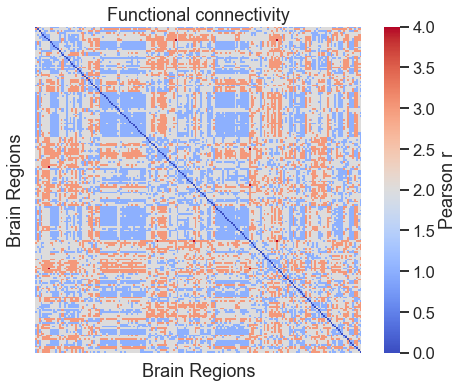

In [102]:
# Visualise FC for the first subject
f = plt.figure(figsize=(8, 6))
hm = sb.heatmap(BinaryDistances,
                xticklabels=False,
                yticklabels=False,
                cmap='coolwarm',
                cbar_kws={'label': 'Pearson r'},
                vmin=np.nanmin(abs(BinaryDistances.flatten())),  # the matrix contains NaN values on the diagonal - this line and the next excludes those from the colormap
                vmax=np.nanmax(abs(BinaryDistances.flatten())))   # (as above)

hm.set_aspect('equal')                # make the heatmap plot square
plt.xlabel('Brain Regions', labelpad=10)
plt.ylabel('Brain Regions', labelpad=10)
plt.title('Functional connectivity')

## Step 7 - Efficiency, hubs and other measures

A number of important graph statistics can be calculated based on shortest path lengths.

The global efficiency of the graph is the inverse of the average path length: if a graph has a short average path length then information can flow quickly from node to node, whereas if the average path length is large, more steps are necessary to move from node to node, on average.

Global efficiency is calculated as:

In [103]:
GE=bct.efficiency_bin(Binary_Thresh_FC_Graph,0)

The second argument '0' tells the command that the global efficiency rather than local efficiency is required. If this is set to '1' instead of '0', then the local efficiency of each node is calculated. The local efficiency is the inverse of the average path length for each node's neighbouring (i.e., connected) nodes. 

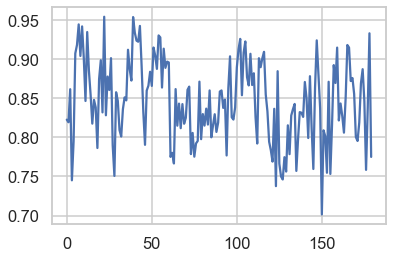

In [104]:
LE=bct.efficiency_bin(Binary_Thresh_FC_Graph,1)
plt.plot(LE)

If we had two or more graphs, we could compare them and see which nodes have the same and which different efficiencies.

Another important measure that relates to the shortest path length is the betweeness centrality. This is a quantitative measure of how hub-like a node is. The betweeness centrality is the proportion of shortest paths that pass through a node. If a node contains a large proportion of the shortest paths, then more communication across the network, on average, will pass through that node. Below is an illustration of betweeness centrality taken from Wikipedia, with nodes coloured by their betweeness centrality; nodes in the centre of the graph, and so a part of many of the shortest paths, are coloured most brightly. 

PIC HERE

To calculate betweenness centrality, we use the 'betweenness_bin' command:  

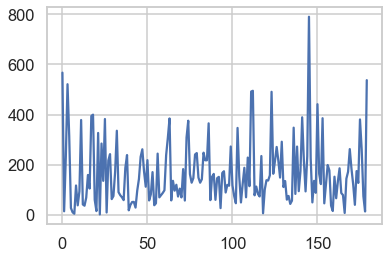

In [186]:
BC=bct.betweenness_bin(Binary_Thresh_FC_Graph)
plt.plot(BC)

You can easily find out, for instance, which ROI identifier has the highest value of betweenness centrality by using the where() function. This function takes as input a logical condition (e.g. values > 5) and it returns the index number of those values that meet the condition.

In [184]:
max_roi = np.where(BC == max(BC))
max_roi

(array([145]),)

This results in the betweenness centrality (hub-iness) of each node. You could investigate further to see which nodes are most hub-like or you could compare these values across different e.g., patient groups or experimental conditions.

You can sort the graph theoretical values and also get the corresponding ROI indices quite simply. We use the sort function which sorts an input vector, but also helpfully will tell us the corresponding indices into those values after sorting, and because the ROIs are contiguously numbered from 1..180, this works perfectly.

Note here the descend option means that the highest scoring values (and indices) will appear first. This code will list the highest-scoring ROIs according to the graph theory metric BC:

In [187]:
BC_sorted = BC

In [188]:
BC_sorted.sort()

In [181]:
max_roi_array = BC_sorted[-10:]
max_roi_array


array([394.15698765, 399.52834324, 441.20701283, 490.74706399,
       491.67560279, 494.75611557, 520.98705022, 537.16609154,
       567.10610468, 790.20920981])

In [182]:
index_max_roi = np.where(BC >= BC_sorted[-10])
index_max_roi

(array([170, 171, 172, 173, 174, 175, 176, 177, 178, 179]),)

You might rightly wonder, what is region X? In the files glasserrois.txt and glassertable.pdf in your data directory is some information to answer this question.

The PDF comes from part of the (enormous) supplementary information from the original publication (see reference above, also glassersomesi.pdf for some of the full neuroanatomical supplementary information available that describes the regions in more detail).

The text file is a simple 'look up table' that maps ROI integer id => ROI name, i.e. here's the first few lines:

1. L_V1_ROI 
2. L_MST_ROI 
3. L_V6_ROI

You could scroll through that file to look up the name of the ROI for a given integer identifier. But lets use the file in Python to do this for us, in a programmatic way. To do this we just need to load the text file in to Python and use the data in the right way.

There are at least 5 ways to load a text file like this in Python. Here we use readtable to load the data as a Python table data structure. This will load both columns fo the file, but we can simplify things by selecting only the second column, which is a cell array of character vectors (e.g. 'L_V1_ROI').

In [189]:
with open('data/glasserrois.txt') as f:
    roiInfo = f.readlines()

Because the ROI numbering is 1,2,..., and python indexing is 0,1,2..., to get the name of ROI integer X, you can just do ROInames[X-1]. Now you can look up an ROI easily: 

In [190]:
roiInfo[2]

'3 L_V6_ROI\n'

Or you can lookup as many indices as you like in one go:

In [191]:
roiInfo[0:10]

['1 L_V1_ROI\n',
 '2 L_MST_ROI\n',
 '3 L_V6_ROI\n',
 '4 L_V2_ROI\n',
 '5 L_V3_ROI\n',
 '6 L_V4_ROI\n',
 '7 L_V8_ROI\n',
 '8 L_4_ROI\n',
 '9 L_3b_ROI\n',
 '10 L_FEF_ROI\n']

Some other things you might like to try before going on to the exercises: 

1. If you have time, explore what effect the sparsity of the graph (i.e., the threshold level you set when binarising edges has). 

2. Explore using weighted/unbinarised measures (e.g., using pairwise_FC_Thresh instead of Binary_Thresh_FC_Graph). 

3. Explore other graph measures from the BCT. 

# Challenge

The resting state data you analysed was actually collected as the placebo condition of a study where the participant took the psychedelic drug LSD. The file fmrilsd.nii.gz contains imaging data for the LSD condition for the same subject (it was subject 12, S12). 

### You need to do the following:

For the same subject, build a graph for the LSD condition (with the same ROIs) that you can compare to the placebo condition, include figures as appropriate

Choose three graph metrics and calculate for both placebo and LSD - what do you find?

Then, carry out a group level analysis. We have made available two datasets, which contain data for subjects undergoing LSD and the same subjects undergoing placebo resting-state scans. The study was published in Carhart-Harris, Robin L., et al. Neural correlates of the LSD experience revealed by multimodal neuroimaging. PNAS, 2016. To help you, we have extracted the ROI time courses for all these scans, and stored lots of other helpful things, in the file groupdata.pickle. So you do not need to extract time courses yourself. 

You can explore the data using whichever graph theory metrics you like. Also inside the groupdata.pickle file is some data providing subject ratings of the LSD experience. Perhaps you could use these in some way.

What if anything does this tell us about the effects of psychedelics on the brain?